In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import random
import seaborn as sns
use_cuda=torch.cuda.is_available()

print(use_cuda)

True


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


IMPORTING THE DATA

In [ ]:
import pickle
import gzip
with gzip.open('/content/gdrive/MyDrive/APS360 Project DATA/MyDataFeatureFull.pkl', 'rb') as f: #\\MyDataFeatureFull
    loaded_data = pickle.load(f)

DATA SPLITTING


In [ ]:
torch.manual_seed(10)
def trim_channels(lst, max_channels=23):
    trimmed_lst = []
    for data, label in lst:
        # If data contains more than max_channels channels, trim it
        if len(data) > max_channels:
            data = data[:max_channels]
        if len(data) == max_channels:
            trimmed_lst.append((data, label))
    return trimmed_lst

loaded_data = trim_channels(loaded_data)

import numpy as np
from sklearn.model_selection import train_test_split
# Extract labels only for stratified splitting
labels = [label for data, label in loaded_data]
# Convert labels to binary (0 = False, 1 = True) for stratification
binary_labels = [1 if label else 0 for label in labels]
# Perform stratified splitting
train_data, temp_data = train_test_split(loaded_data, stratify=binary_labels, test_size=0.4)
# Now split the temporary set into equal halves of validation and test sets.
binary_labels_temp = [1 if label else 0 for data, label in temp_data]
val_data, test_data = train_test_split(temp_data, stratify=binary_labels_temp, test_size=0.5)

from sklearn.utils import resample
# separate the True and False samples in train_data
true_setT = [data for data in train_data if data[1] == True]
false_setT = [data for data in train_data if data[1] == False]
# oversample True class in train_data
true_setT_oversampled = resample(true_setT, replace=True, n_samples=len(false_setT), random_state=123)
# undersample False class in train_data
false_setT_undersampled = resample(false_setT, replace=False, n_samples=len(true_setT_oversampled), random_state=123)
# combine them to create a balanced train dataset
balanced_train = true_setT_oversampled + false_setT_undersampled
# shuffle the data
random.shuffle(balanced_train)
# separate the True and False samples in val_data
true_setV = [data for data in val_data if data[1] == True]
false_setV = [data for data in val_data if data[1] == False]
# oversample True class in val_data
true_setV_oversampled = resample(true_setV, replace=True, n_samples=len(false_setV), random_state=123)
# undersample False class in val_data
false_setV_undersampled = resample(false_setV, replace=False, n_samples=len(true_setV_oversampled), random_state=123)
# combine them to create a balanced validation dataset
balanced_val = true_setV_oversampled + false_setV_undersampled
# shuffle the data
random.shuffle(balanced_val)
print(len(false_setT_undersampled))
print(len(true_setT_oversampled))

# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

# def minmax_scale_data(data):
#     """Scale the features in a dataset to a range between 0 and 1."""
#     scaler = MinMaxScaler()
#     return [(scaler.fit_transform(features), label) for features, label in data]

# # Apply the MinMax scaling
# train_dataN = minmax_scale_data(balanced_train)
# val_dataN = minmax_scale_data(balanced_val)
# test_dataN = minmax_scale_data(test_data)


def get_metrics(model, data, batch_size):
    torch.manual_seed(1)
    correct = 0
    total = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    tn = 0  # True negatives
    counter = 0


    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        imgs = imgs.unsqueeze(1)
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            model = model.cuda()
        output = model(imgs.float())
        counter +=1

        pred = output.max(1, keepdim=True)[1]
        pred = pred.squeeze()
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        tp += ((pred == 1) & (labels == 1)).sum().item()
        fp += ((pred == 1) & (labels == 0)).sum().item()
        fn += ((pred == 0) & (labels == 1)).sum().item()
        tn += ((pred == 0) & (labels == 0)).sum().item()


    accuracy = correct / total
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0
    recall = tp / (tp + fn) if tp + fn != 0 else 0.0
    f1 = 2*((recall*precision)/(recall+precision)) if recall + precision != 0 else 0.0
    confusion_matrix = torch.tensor([[tp, fp], [fn, tn]])

    return accuracy, recall, precision, f1, confusion_matrix


38910
38910


MODELS

In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, name="EEG_CNN"):
        super(EEG_CNN,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1)
        self.pool = nn.MaxPool2d(2,2)

        # Adjust dimensions for fully connected layers
        self.fc1 = nn.Linear(64*5*2, 10)  # self.fc1 = nn.Linear(64*5*2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # output dimensions: [32, 11, 4]
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x))) # output dimensions: [64, 5, 2]
        # print(x.size())
        x = x.view(-1, 64*5*2) # flatten layer x.view(-1, 64*5*2) (-1, 64,23,9) x.view(x.size(0), -1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # print(x.size())
        return x

In [ ]:
class ANN_MNISTClassifier(nn.Module):
    def __init__(self, name="EEG_CNN"):
        super(ANN_MNISTClassifier, self).__init__()

        self.name=name

        self.fc1 = nn.Linear(23*9, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, img):
        flattened = img.view(-1, 23*9)
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(activation1))
        output = self.fc3(activation2)
        return output

In [ ]:
class EEG_CNN2(nn.Module):
    def __init__(self, name="EEG_CNN2"):
        super(EEG_CNN2,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=(1))
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=(1))
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding=(1))  # Additional convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(.5)  # Dropout for regularization

        # Adjust dimensions for fully connected layers
        # Update dimensions based on the output size from the conv layers
        self.fc1 = nn.Linear(128*2*1, 64)  # Adjusted based on conv3 and pooling layers
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 2)  # Additional fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Add batch norm after conv1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Add batch norm after conv2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Add conv3 and batch norm

        x = x.view(-1, 128*2*1)  # Flatten layer, adjust based on conv3 and pooling layers
        x = self.dropout(F.relu(self.fc1(x)))  # Add dropout after activation
        x = self.dropout(F.relu(self.fc2(x)))  # Add dropout after activation

        x = self.fc3(x)  # Additional fully connected layer
        return x

In [ ]:
class EEG_CNN3(nn.Module):
    def __init__(self, name="EEG_CNN3"):
        super(EEG_CNN3,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=(1))
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=(1))
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding=(1))  # Additional convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.pool = nn.MaxPool2d(2,2)

        # Adjust dimensions for fully connected layers
        # Update dimensions based on the output size from the conv layers
        self.fc1 = nn.Linear(128*2*1, 64)  # Adjusted based on conv3 and pooling layers
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Additional fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Add batch norm after conv1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Add batch norm after conv2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Add conv3 and batch norm

        x = x.view(-1, 128*2*1)  # Flatten layer, adjust based on conv3 and pooling layers

        x = F.relu(self.fc1(x))  # Add dropout after activation
        x = F.relu(self.fc2(x))  # Add dropout after activation

        x = self.fc3(x)  # Additional fully connected layer
        return x

In [ ]:
class EEG_CNNc(nn.Module): # highest precision + recall
    def __init__(self, name="EEG_CNNc"):
        super(EEG_CNNc,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=(1))
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=(1))
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding=(1))  # Additional convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

        # Adjust dimensions for fully connected layers
        # Update dimensions based on the output size from the conv layers
        self.fc1 = nn.Linear(128*2*1, 64)  # Adjusted based on conv3 and pooling layers
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 2)  # Additional fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Add batch norm after conv1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Add batch norm after conv2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Add conv3 and batch norm

        x = x.view(-1, 128*2*1)  # Flatten layer, adjust based on conv3 and pooling layers
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))  # Add BN before activation and dropout after activation
        x = self.dropout(F.relu(self.bn5(self.fc2(x))))  # Add BN before activation and dropout after activation

        x = self.fc3(x)  # Additional fully connected layer
        return x

In [ ]:
class EEG_CNNb(nn.Module): # NO BATCH NORM
    def __init__(self, name="EEG_CNNb"):
        super(EEG_CNNb,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=(1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=(1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding=(1))  # Additional convolutional layer
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

        # Adjust dimensions for fully connected layers
        # Update dimensions based on the output size from the conv layers
        self.fc1 = nn.Linear(128*2*1, 64)  # Adjusted based on conv3 and pooling layers
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Additional fully connected layer

    def forward(self, x):


        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128*2*1)  # Flatten layer, adjust based on conv3 and pooling layers
        x = self.dropout(F.relu(self.fc1(x)))  # Add dropout after activation
        x = self.dropout(F.relu(self.fc2(x)))  # Add dropout after activation
        x = self.fc3(x)  # Additional fully connected layer
        return x

TRAINING FUNCTIONS

In [ ]:
def get_metrics(model, data, batch_size):
    torch.manual_seed(1)
    correct = 0
    total = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    tn = 0  # True negatives
    counter = 0


    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        imgs = imgs.unsqueeze(1)
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            model = model.cuda()
        output = model(imgs.float())
        counter +=1

        pred = output.max(1, keepdim=True)[1]
        pred = pred.squeeze()
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        tp += ((pred == 1) & (labels == 1)).sum().item()
        fp += ((pred == 1) & (labels == 0)).sum().item()
        fn += ((pred == 0) & (labels == 1)).sum().item()
        tn += ((pred == 0) & (labels == 0)).sum().item()


    accuracy = correct / total
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0
    recall = tp / (tp + fn) if tp + fn != 0 else 0.0
    f1 = 2*((recall*precision)/(recall+precision)) if recall + precision != 0 else 0.0
    confusion_matrix = torch.tensor([[tp, fp], [fn, tn]])

    return accuracy, recall, precision, f1, confusion_matrix


In [ ]:
def train(model, train_data, val_data, batch_size, num_epochs, learning_rate=0.01, MASTER_SAVE=True, save_last=5):
    torch.manual_seed(1)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    criterion = nn.CrossEntropyLoss()  #criterion = nn.CrossEntropyLoss(weight=class_weights)

    epoch = 0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    counter = 0
    epochs, iters, losses, train_acc, val_acc = [], [], [], [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_f1, val_f1 = [],[]
    ct = 0
    n = 0
    model.to(device)


    # Current model's metrics - validation
    highest_accuracy = -1.0
    highest_precision = -1.0
    highest_recall = -1.0
    highest_f1 = -1.0


    best_paths = [' ',' ',' ',' ']

    for epoch in range(num_epochs):
        random.seed(1)
        random.shuffle(train_data)
        random.shuffle(val_data)
        tp = 0  # True positives
        fp = 0  # False positives
        fn = 0  # False negatives
        tn = 0  # True negatives

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        for imgs, labels in iter(train_loader):
            imgs = imgs.unsqueeze(1)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            counter +=1
            labels = labels.long()  # Change labels to long
            if use_cuda and torch.cuda.is_available():
                model.cuda()
            else:
                device = torch.device("cpu")

            out = model(imgs.float())
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iters.append(n)
            losses.append(float(loss)/batch_size)
            n += 1

            # print((out[0][0]))
            # print(len(out[0]))
            # pred = out.max(1, keepdim=True)[1]
            # # for i in range(len(pred)):
            # #     tp += ((pred[i][0] == 1) & (labels[i] == 1))
            # #     fp += ((pred[i][0] == 1) & (labels[i] == 0))
            # #     fn += ((pred[i][0] == 0) & (labels[i] == 1))
            # #     tn += ((pred[i][0] == 0) & (labels[i] == 0))
            # # print((pred == 1)[0])
            # pred = pred.squeeze()
            # # print(pred)
            # # print(1,(pred)[1])
            # # print(2,(labels)[1])
            # # print((pred)[0]==(labels)[0])
            # # print((pred[0] == 1) & (labels[0] == 1))
            # tp += ((pred == 1) & (labels == 1)).sum().item()
            # fp += ((pred == 1) & (labels == 0)).sum().item()
            # fn += ((pred == 0) & (labels == 1)).sum().item()
            # tn += ((pred == 0) & (labels == 0)).sum().item()
            # print(tn)
            # accuracyT, recallT, precisionT, f1T = get_metrics(model, train_data, batch_size=batch_size)
            # train_acc.append(accuracyT)
            # accuracyV, recallV, precisionV, f1V = get_metrics(model, val_data, batch_size=batch_size)
            # val_acc.append(accuracyV)


        # If a large amount of epochs, only print every 5
        if(num_epochs >= 100):
          if(epoch % 5 == 0):
            print(epoch)
        else:
          print(epoch)


        epochs.append(epoch)
        epoch +=1
        accuracyT, recallT, precisionT, f1T, confusion_matrixT  = get_metrics(model, train_data, batch_size=batch_size)
        train_acc.append(accuracyT)
        accuracyV, recallV, precisionV, f1V, confusion_matrixV = get_metrics(model, val_data, batch_size=batch_size)
        val_acc.append(accuracyV)

        train_precision.append(precisionT)
        val_precision.append(precisionV)

        train_recall.append(recallT)
        val_recall.append(recallV)

        train_f1.append(f1T)
        val_f1.append(f1V)

        # Update models 'highest metrics'
        highest_accuracy = (highest_accuracy, accuracyV)[accuracyV > highest_accuracy]
        highest_precision = (highest_precision, precisionV)[precisionV > highest_precision]
        highest_recall = (highest_recall, recallV)[recallV > highest_recall]
        highest_f1 = (highest_f1, f1V)[f1V > highest_f1]

        do_save, reason = determine_save(accuracyV, recallV, precisionV, f1V,
                                         highest_accuracy, highest_precision,
                                         highest_recall, highest_f1, epoch, num_epochs,save_last)


        if(MASTER_SAVE and do_save):
          model_path = get_model_name(model.name, batch_size,learning_rate, accuracyV, recallV, precisionV, f1V, epoch, reason)
          best_paths[reason] = model_path
          save_model(model, model_path)

    print(n)
        # print(epoch)
    plt.title('Training Curve (' + str(model.name) + ')')
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    print(len(epochs))
    print(len(train_acc))
    # Accuracy
    plt.title('Accuracy Curve (' + str(model.name) + ')')
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Precision
    plt.title('Precision Curve (' + str(model.name) + ')')
    plt.plot(epochs, train_precision, label="Train")
    plt.plot(epochs, val_precision, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend(loc='best')
    plt.show()

    # Recall
    plt.title('Recall Curve (' + str(model.name) + ')')
    plt.plot(epochs, train_recall, label="Train")
    plt.plot(epochs, val_recall, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend(loc='best')
    plt.show()

    # F1
    plt.title('F1 Curve (' + str(model.name) + ')')
    plt.plot(epochs, train_f1, label="Train")
    plt.plot(epochs, val_f1, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(loc='best')
    plt.show()

    # print(tp+fp+fn+tn)
    # confusion_matrix = torch.tensor([[tp, fp], [fn, tn]])
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrixT.cpu(), annot=True, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix for Validation Data (' + str(model.name) + ')')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Accuracy/recall/precision/f1:", accuracyT, recallT, precisionT, f1T)
    print("Final Validation Accuracy/recall/precision/f1:", accuracyV, recallV, precisionV, f1V)

    print("\nHighest of each metric:")
    print("USE THESE TO UPDATE get_save_metrics (copy paste)")
    print("save_accuracy = " + str(highest_accuracy))
    print("save_precision = " + str(highest_precision))
    print("save_recall = " + str(highest_recall))
    print("save_f1 = " + str(highest_f1))

    print("\nCorresponding Model Names: ")
    print("DOWNLOAD THESE -> BEST YOU HAVE SO FAR")
    print("Accuracy: " + str(best_paths[0]))
    print("Precision: " + str(best_paths[1]))
    print("Recall: " + str(best_paths[2]))
    print("F1: " + str(best_paths[3]))

In [ ]:
#MUST UPDATE THESE AFTER EACH TRAINING MODEL

# PASTE HERE
def get_save_metrics():

  save_recall = 0.75
  save_accuracy = 0.99
  save_precision = 0.8
  save_f1 = 0.78

  # save_accuracy = 0.9946179502728927
  # # save_precision = 1.0
  # save_recall = 0.8558558558558559
  # save_f1 = 0.8375286041189931

  return save_accuracy, save_precision, save_recall, save_f1

def determine_save(accuracy, recall, precision, f1,
                                         highest_accuracy, highest_precision,
                                         highest_recall, highest_f1, epoch, num_epochs, save_last=5):
  save_accuracy, save_precision, save_recall, save_f1 = get_save_metrics()
  do_save = False

  # CHANGE TO WIDEN SAVE WINDOW
  # save_last = 25

  if(epoch >= (num_epochs-save_last)):

    save_accuracy = (save_accuracy, highest_accuracy)[highest_accuracy > save_accuracy]
    save_precision = (save_precision, highest_precision)[highest_precision > save_precision]
    save_recall = (save_recall, highest_recall)[highest_recall > save_recall]
    save_f1 = (save_f1, highest_f1)[highest_f1 > save_f1]

    if(f1 >= save_f1):
      do_save = True
      return do_save, 3

    if(precision >= save_precision):
      do_save = True
      return do_save, 1

    if(recall >= save_recall):
      do_save = True
      return do_save, 2

    if(accuracy >= save_accuracy):
      do_save = True
      return do_save, 0

  return False, -1


def save_model(model, path):
  torch.save(model.state_dict(), path)


def get_model_name(name, batch_size, learning_rate, accuracy, recall, precision, f1, epoch, basis):

  accuracy = accuracy * 100
  recall = recall * 100
  precision = precision * 100
  f1 = f1 * 100

  # basis = basis[0].upper()

  word = ' '

  match basis:
    case 0:
      word = 'accuracy'
    case 1: word = 'precision'
    case 2: word = 'recall'
    case 3: word = 'f1'
    case _: word = 'error'

  path = "{reason}_{0}_bs{1}_lr{2}_a{3:.2f}_r{4:.2f}_p{5:.2f}_f{6:.2f}_epoch{7}".format(
                                  name,
                                  batch_size,
                                  learning_rate,
                                  accuracy,
                                  recall,
                                  precision,
                                  f1,
                                  epoch,
                                  reason=word)

  return path



In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

TRAINING BEGINS


In [ ]:
torch.manual_seed(1)
fc_bn = EEG_CNNc(name="fc_bn")
if use_cuda and torch.cuda.is_available():
  with_dropout.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(fc_bn, train_data, val_data, batch_size=batch_size, num_epochs = 25)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
3875


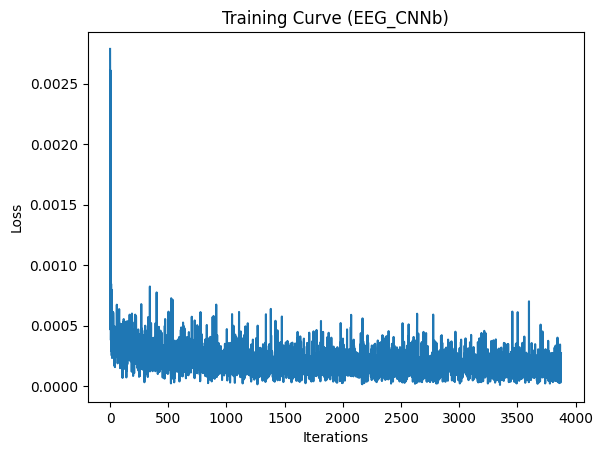

25
25


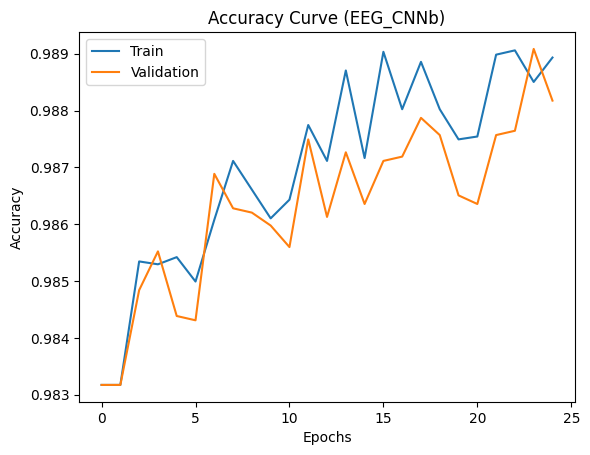

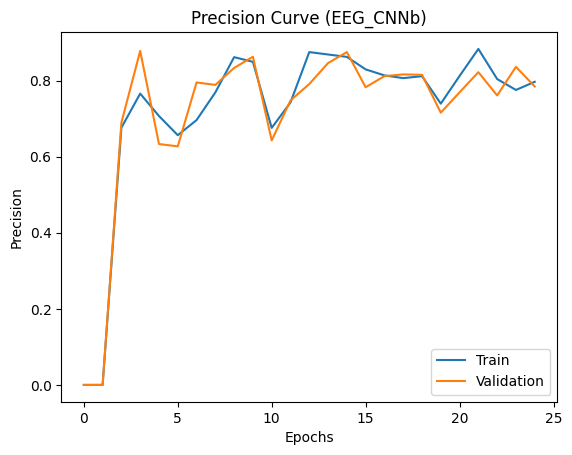

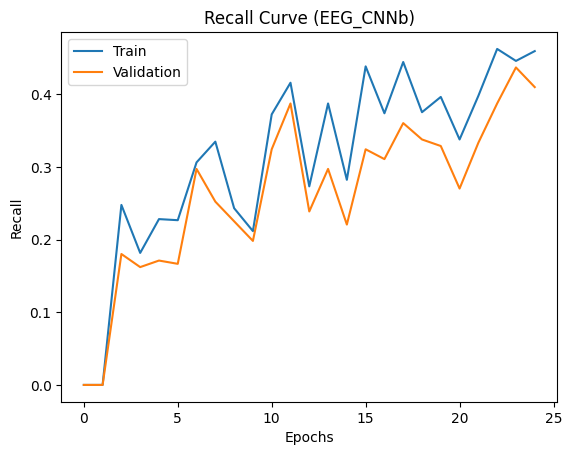

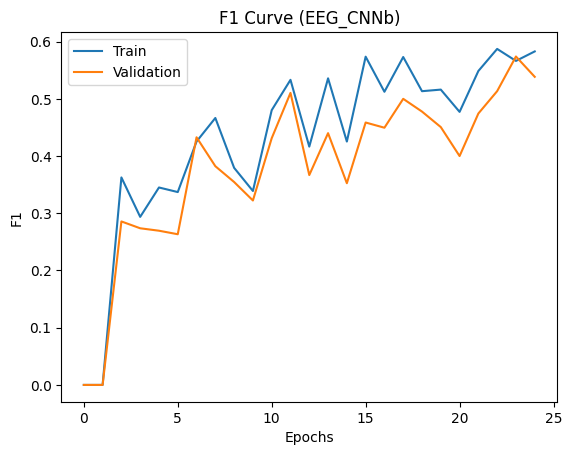

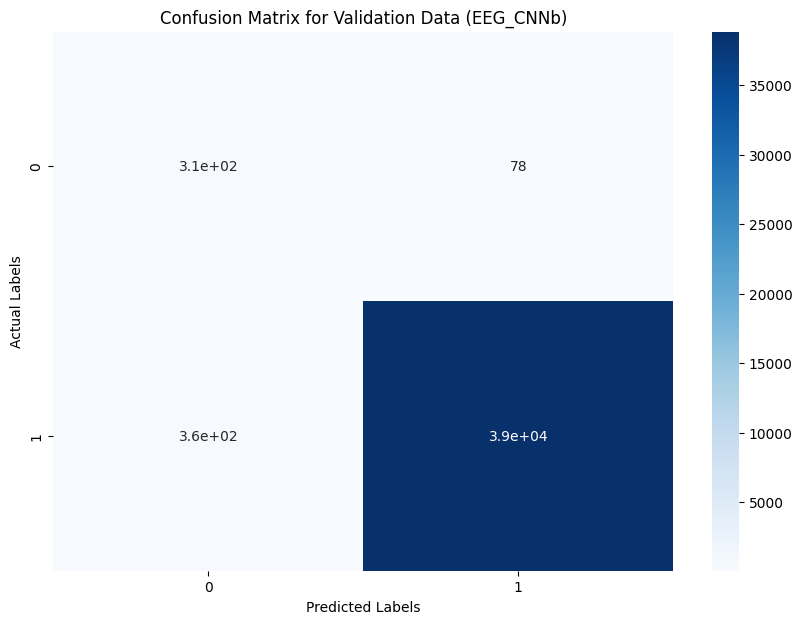

Final Training Accuracy: 0.9889326864766526
Final Validation Accuracy: 0.9881746513038205
Final Training Accuracy/recall/precision/f1: 0.9889326864766526 0.4594594594594595 0.796875 0.582857142857143
Final Validation Accuracy/recall/precision/f1: 0.9881746513038205 0.4099099099099099 0.7844827586206896 0.5384615384615385

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.989084293511219
save_precision = 0.8780487804878049
save_recall = 0.4369369369369369
save_f1 = 0.57396449704142

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
torch.manual_seed(1)
with_dropoutss = EEG_CNNb()
if use_cuda and torch.cuda.is_available():
  with_dropoutss.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(with_dropoutss, train_data, val_data, batch_size=batch_size, num_epochs = 25, MASTER_SAVE=False)

In [ ]:
torch.manual_seed(1)
fc_bn_DA_MOST = EEG_CNNc(name="fc_bn_DA_MOST")
if use_cuda and torch.cuda.is_available():
  fc_bn_DA_MOST.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(fc_bn_DA_MOST, train_data, val_data, batch_size=batch_size, num_epochs = 750, save_last=600)

In [ ]:
torch.manual_seed(1)
fc_bn_EVEN_MORE = EEG_CNNc(name="fc_bn_EVEN_MORE")
if use_cuda and torch.cuda.is_available():
  fc_bn_EVEN_MORE.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(fc_bn_EVEN_MORE, train_data, val_data, batch_size=batch_size, num_epochs = 500, save_last=400)

In [ ]:
torch.manual_seed(1)
fc_bn_MORE = EEG_CNNc(name="fc_bn_MORE")
if use_cuda and torch.cuda.is_available():
  with_dropout.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(fc_bn_MORE, train_data, val_data, batch_size=batch_size, num_epochs = 100)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
9300


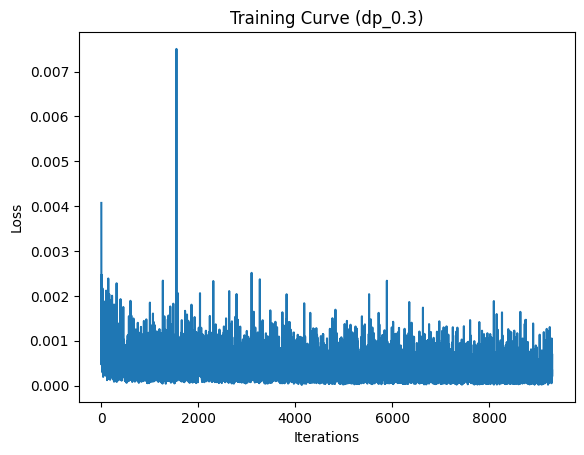

30
30


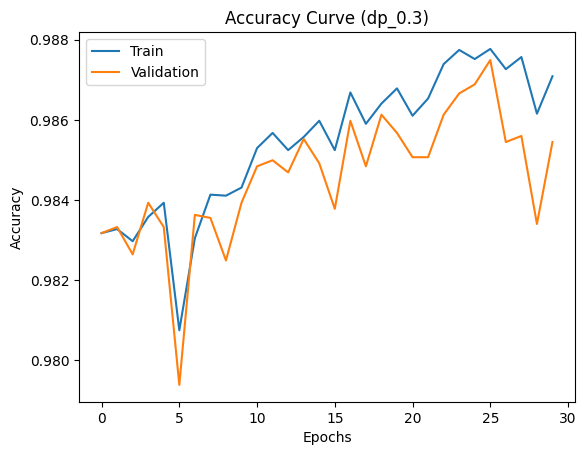

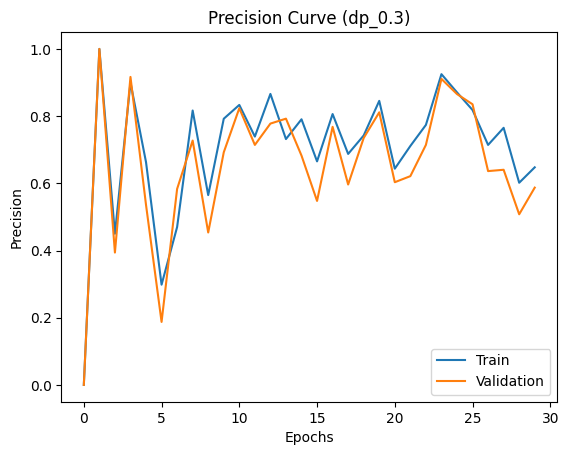

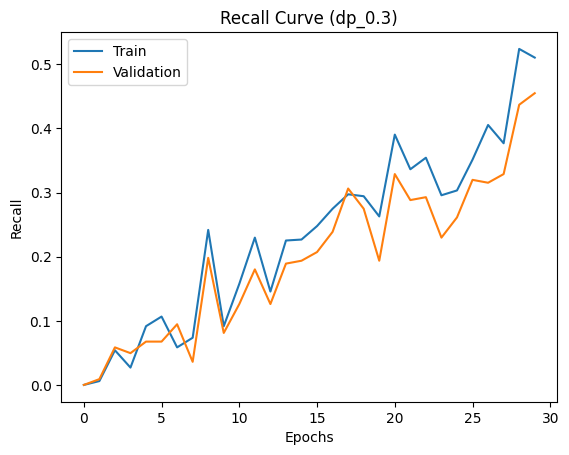

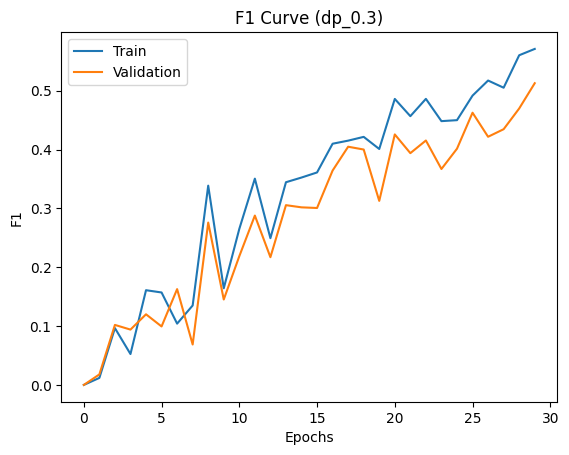

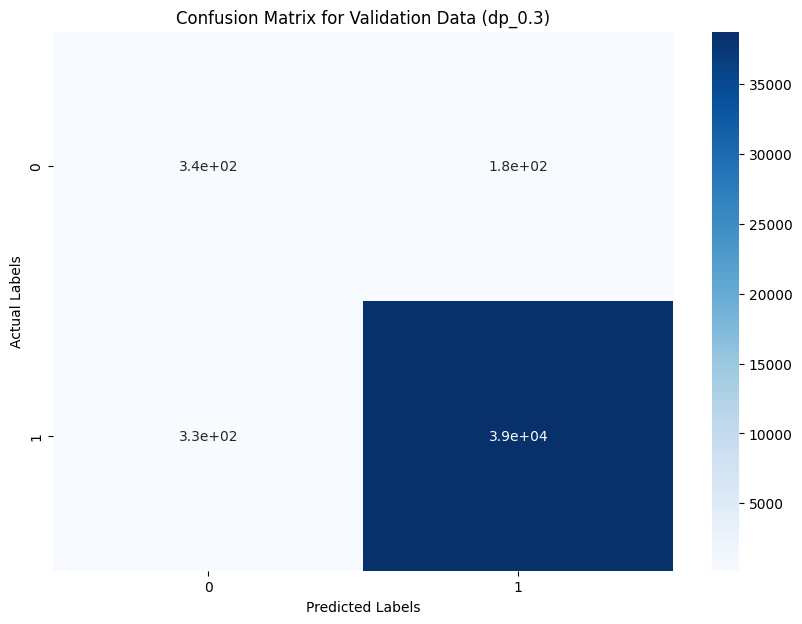

Final Training Accuracy: 0.9870881342227613
Final Validation Accuracy: 0.9854457246816253
Final Training Accuracy/recall/precision/f1: 0.9870881342227613 0.5105105105105106 0.6476190476190476 0.5709487825356843
Final Validation Accuracy/recall/precision/f1: 0.9854457246816253 0.45495495495495497 0.5872093023255814 0.5126903553299492

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.9874924196482717
save_precision = 1.0
save_recall = 0.45495495495495497
save_f1 = 0.5126903553299492

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
torch.manual_seed(1)
with_dropout = EEG_CNN2(name="dp_0.3")
if use_cuda and torch.cuda.is_available():
  with_dropout.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=128
train(with_dropout, train_data, val_data, batch_size=batch_size, num_epochs = 30)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
15200


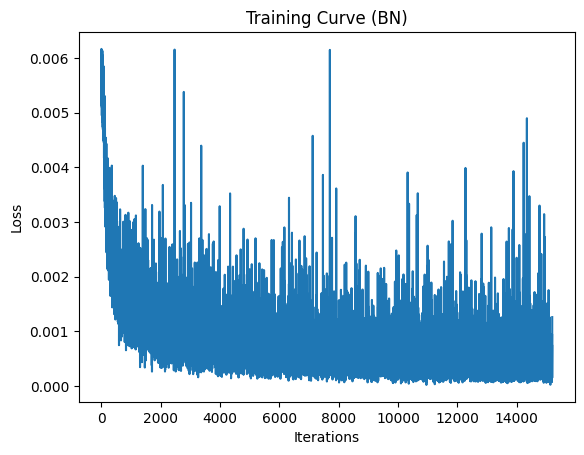

25
25


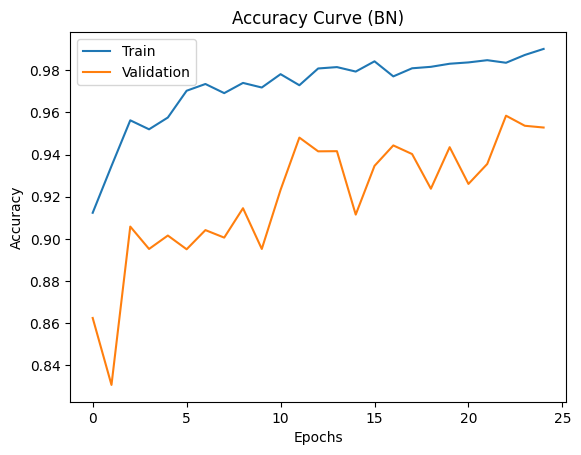

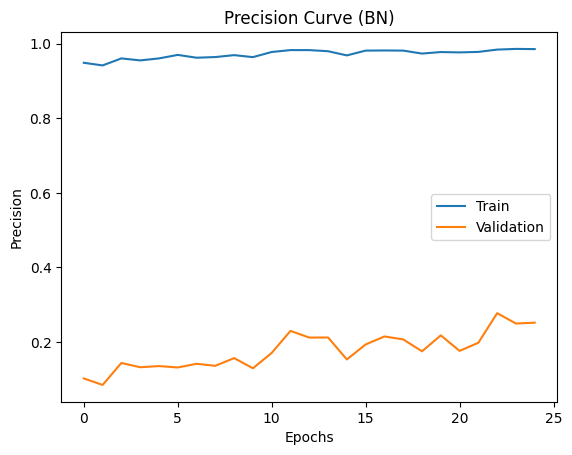

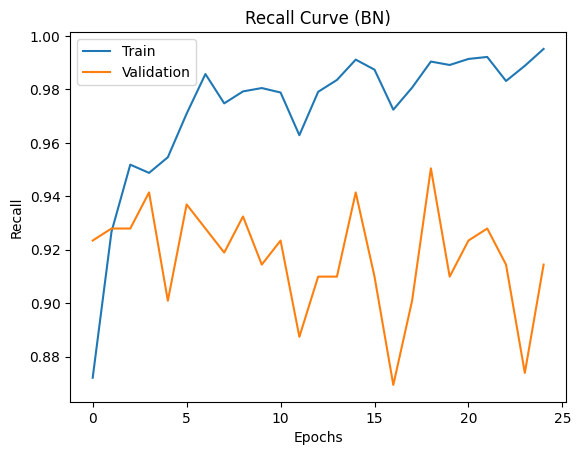

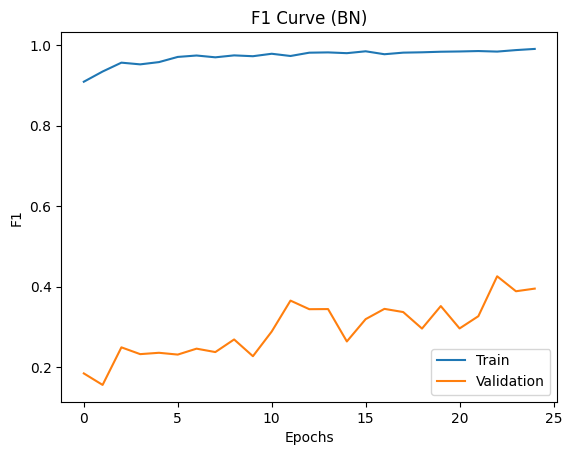

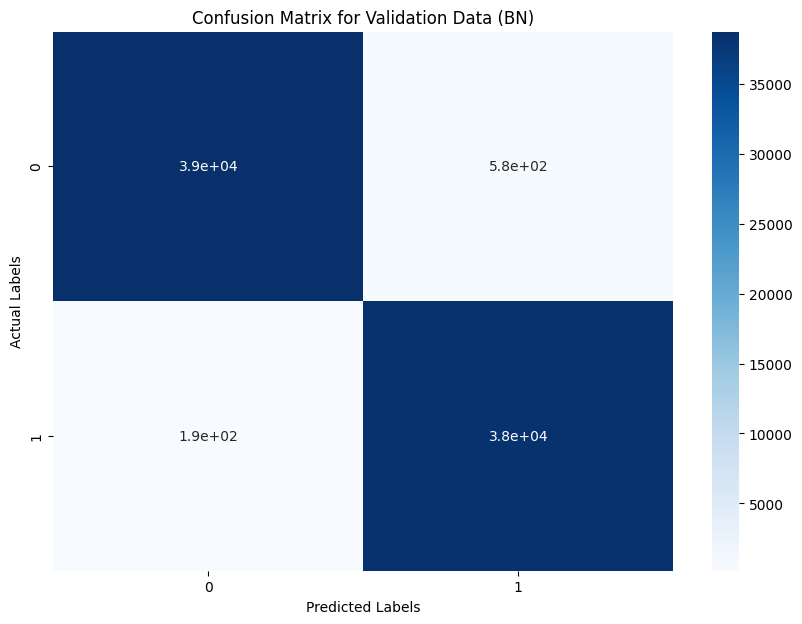

Final Training Accuracy: 0.9901439218709843
Final Validation Accuracy: 0.9528502122498483
Final Training Accuracy/recall/precision/f1: 0.9901439218709843 0.9951683371883835 0.985267550444009 0.9901931953305801
Final Validation Accuracy/recall/precision/f1: 0.9528502122498483 0.9144144144144144 0.2518610421836228 0.39494163424124507

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.9584596725288054
save_precision = 0.2773224043715847
save_recall = 0.9504504504504504
save_f1 = 0.4255765199161425

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
with_BN = EEG_CNN2(name="BN")
if use_cuda and torch.cuda.is_available():
  with_BN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=128
train(with_BN, balanced_train, val_data, batch_size=batch_size, num_epochs = 25)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
7600


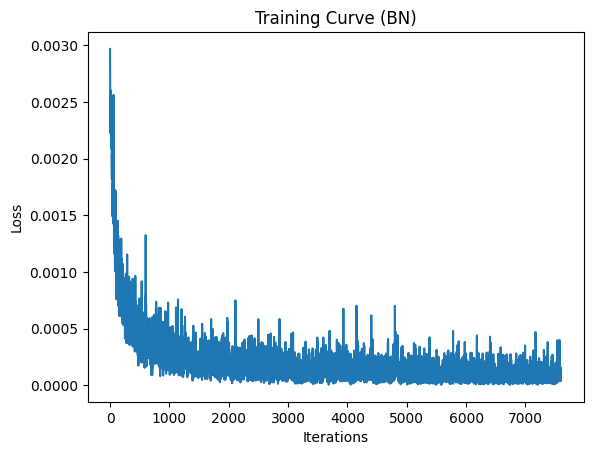

25
25


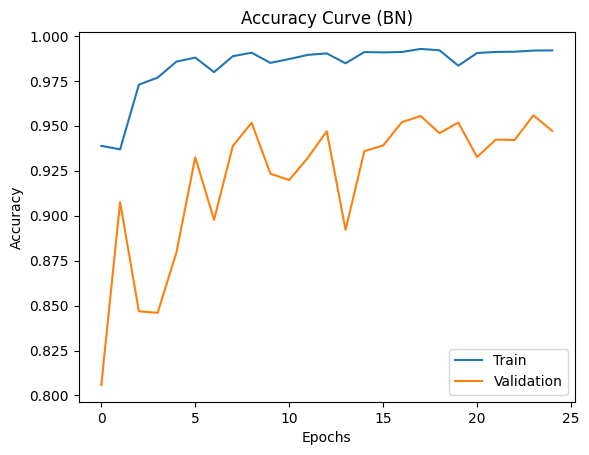

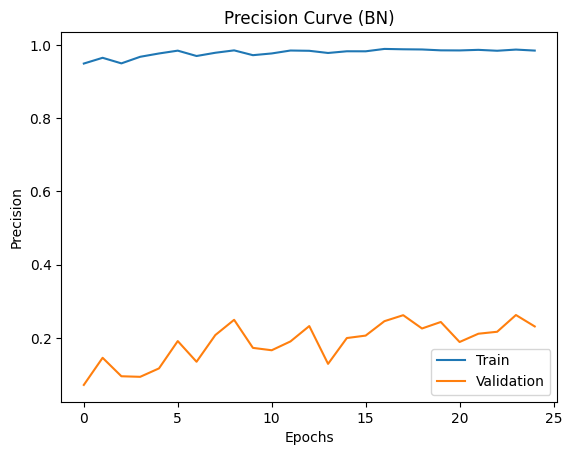

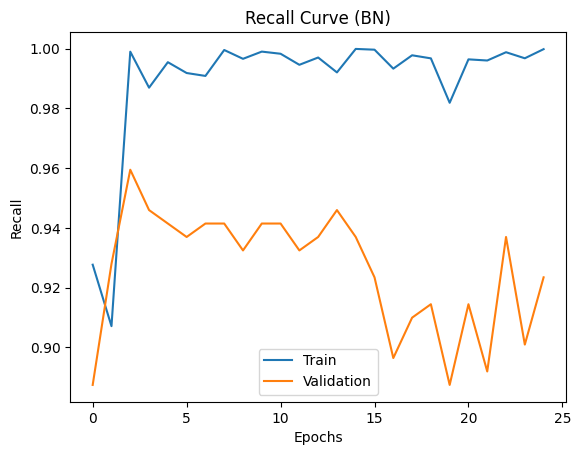

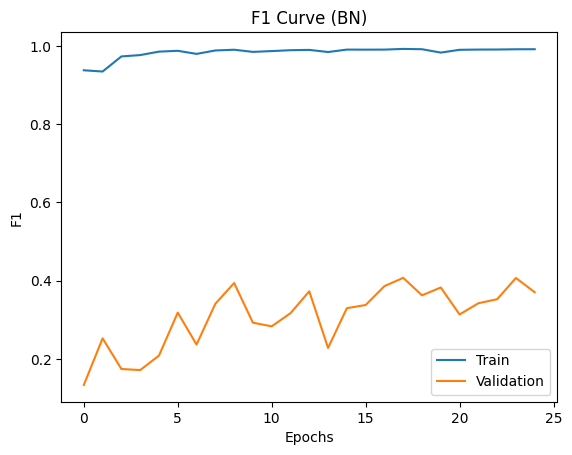

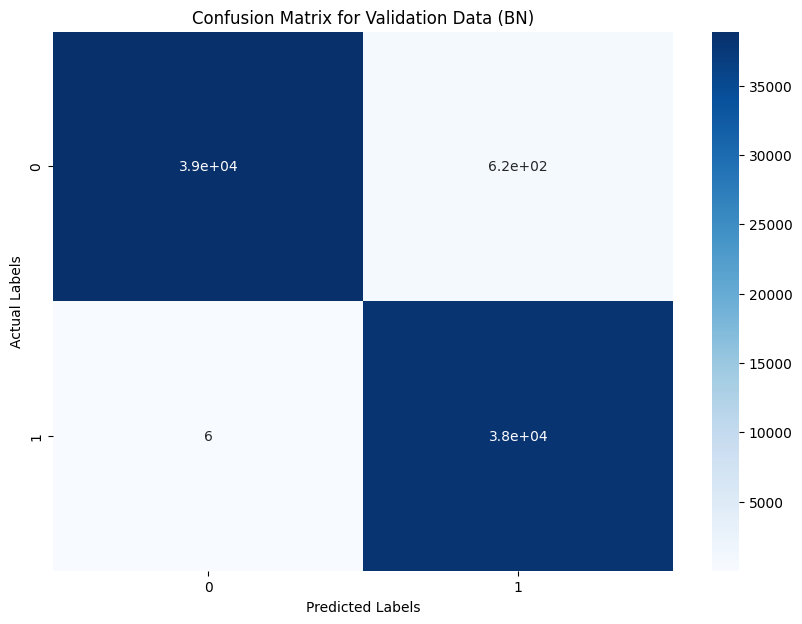

Final Training Accuracy: 0.9919300950912362
Final Validation Accuracy: 0.9471649484536082
Final Training Accuracy/recall/precision/f1: 0.9919300950912362 0.999845797995374 0.9842635227445226 0.9919934723851292
Final Validation Accuracy/recall/precision/f1: 0.9471649484536082 0.9234234234234234 0.23163841807909605 0.37037037037037035

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.9558065494238933
save_precision = 0.2628120893561104
save_recall = 0.9594594594594594
save_f1 = 0.407258064516129

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
with_BN2 = EEG_CNN3(name="BN")
if use_cuda and torch.cuda.is_available():
  with_BN2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=256
train(with_BN2, balanced_train, val_data, batch_size=batch_size, num_epochs = 25)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
15200


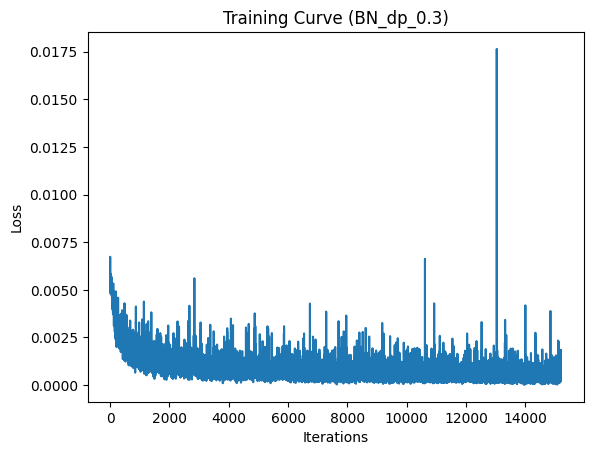

25
25


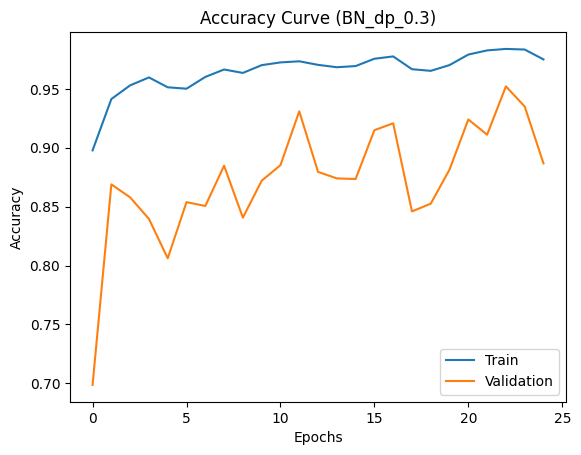

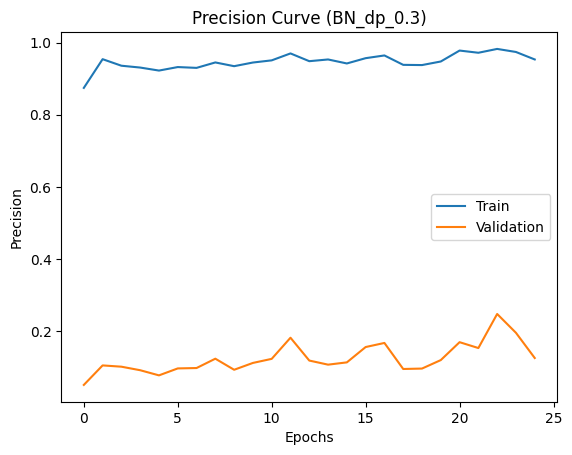

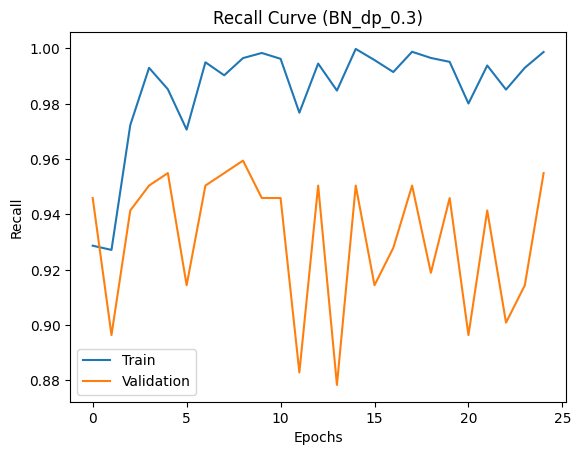

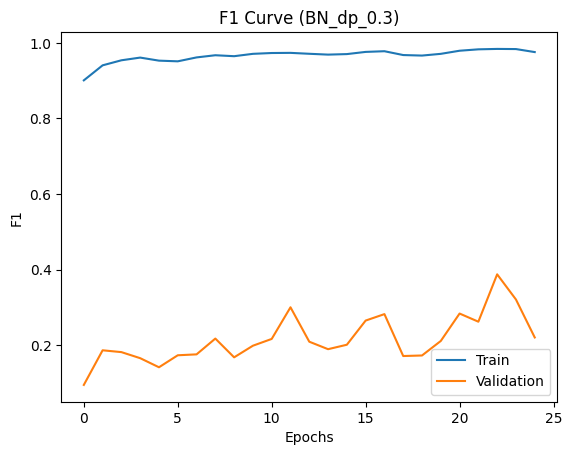

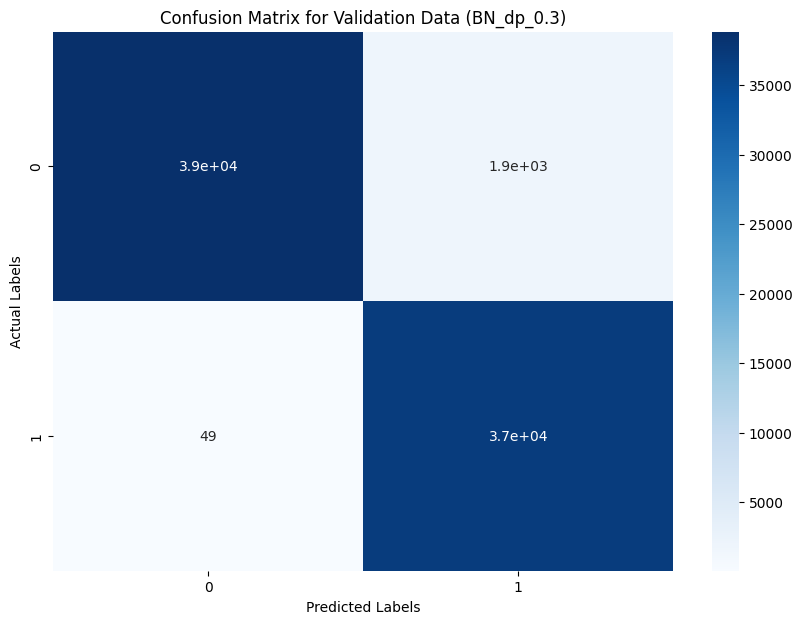

Final Training Accuracy: 0.9750192752505783
Final Validation Accuracy: 0.8867495451788963
Final Training Accuracy/recall/precision/f1: 0.9750192752505783 0.9987406836288871 0.9535037785847482 0.9755981221600181
Final Validation Accuracy/recall/precision/f1: 0.8867495451788963 0.954954954954955 0.125 0.2210636079249218

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.9521679805942995
save_precision = 0.24721878862793573
save_recall = 0.9594594594594594
save_f1 = 0.38797284190106696

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
with_BN_dropout = EEG_CNN2(name="BN_dp_0.3")
if use_cuda and torch.cuda.is_available():
  with_BN_dropout.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=128
train(with_BN_dropout, balanced_train, val_data, batch_size=batch_size, num_epochs = 25)

CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
15200


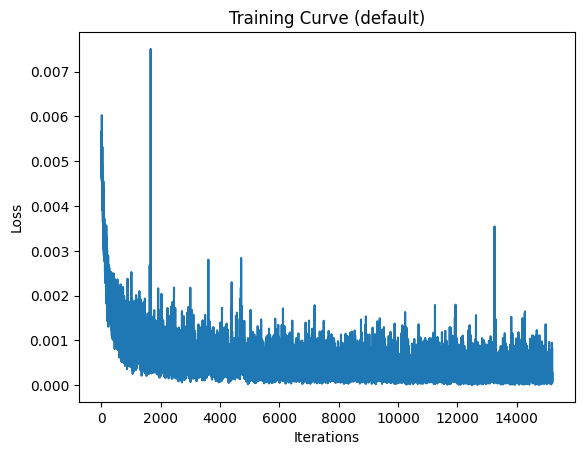

25
25


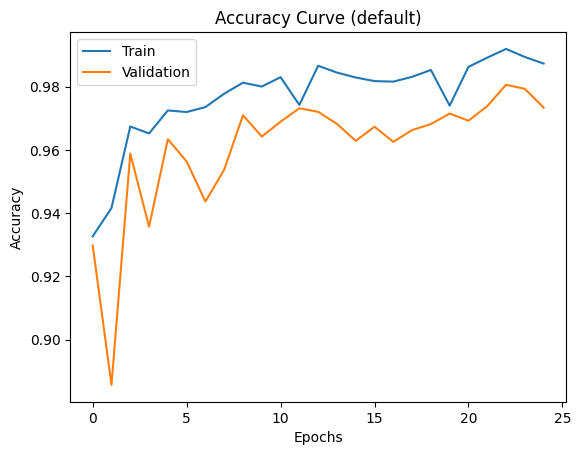

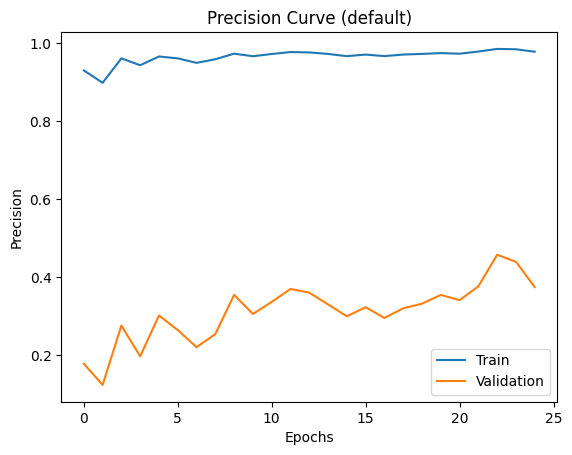

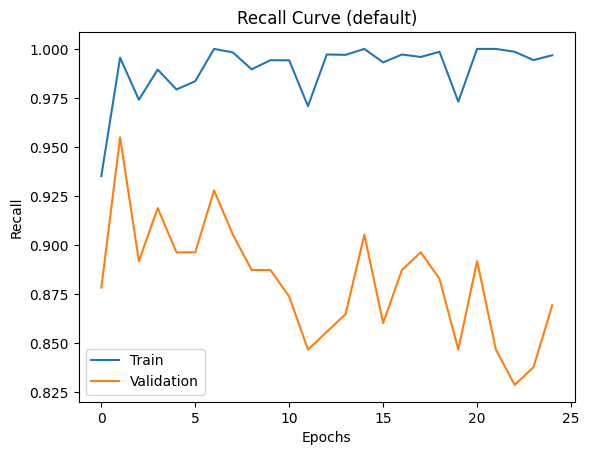

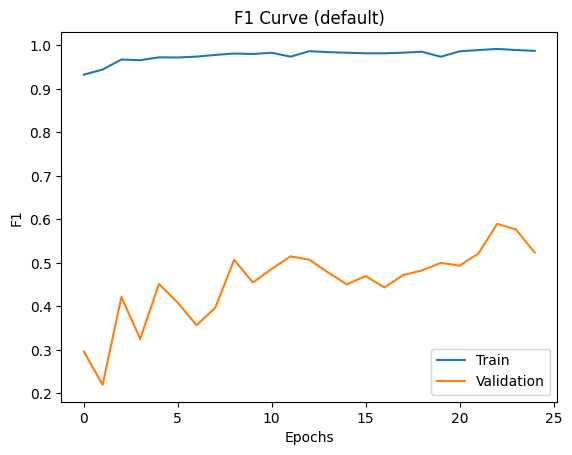

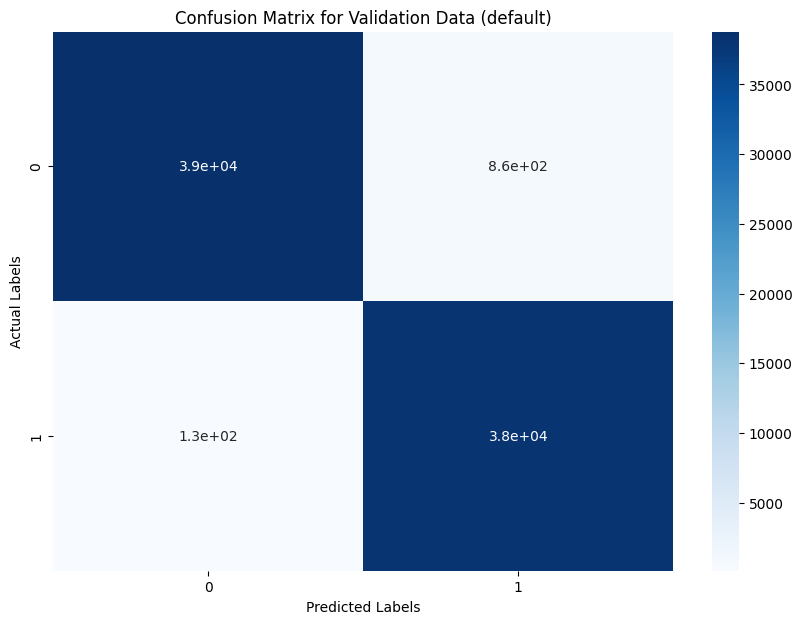

Final Training Accuracy: 0.9873040349524543
Final Validation Accuracy: 0.9733929654335961
Final Training Accuracy/recall/precision/f1: 0.9873040349524543 0.9967617579028527 0.9782575795792766 0.9874229848770304
Final Validation Accuracy/recall/precision/f1: 0.9733929654335961 0.8693693693693694 0.37475728155339805 0.5237449118046134

Highest of each metric:
USE THESE TO UPDATE get_save_metrics (copy paste)
save_accuracy = 0.9805942995755003
save_precision = 0.4577114427860697
save_recall = 0.954954954954955
save_f1 = 0.5897435897435896

Corresponding Model Names: 
DOWNLOAD THESE -> BEST YOU HAVE SO FAR
Accuracy:  
Precision:  
Recall:  
F1:  


In [ ]:
default_CNN = EEG_CNN(name="default")
# if use_cuda and torch.cuda.is_available():
#   cnn.cuda()
torch.manual_seed(10)
if use_cuda and torch.cuda.is_available():
  default_CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
batch_size=128
train(default_CNN, balanced_train, val_data, batch_size=batch_size, num_epochs = 25)

SVM MODEL and TUNING

In [ ]:
#BASELINE MODEL



from sklearn.utils import resample
from sklearn.model_selection import train_test_split
def trim_channels(lst, max_channels=23):
    trimmed_lst = []
    for data, label in lst:
        # If data contains more than max_channels channels, trim it
        if len(data) > max_channels:
            data = data[:max_channels]
        if len(data) == max_channels:
            trimmed_lst.append((data, label))
    return trimmed_lst

loaded_data = trim_channels(loaded_data)
print(len(loaded_data))
# separate the True and False samples in train_data
true_setSVM = [data for data in loaded_data if data[1] == True]
false_setSVM = [data for data in loaded_data if data[1] == False]
# undersample False class in train_data
false_setSVM_undersampled = resample(false_setSVM, replace=False, n_samples=len(true_setSVM), random_state=123)
# oversample True class in train_data
true_setSVM_oversampled = resample(true_setSVM, replace=True, n_samples=len(false_setSVM_undersampled), random_state=123)

# # oversample True class in train_data
# true_setSVM_oversampled = resample(true_setSVM, replace=True, n_samples=len(false_setSVM), random_state=123)
# # undersample False class in train_data
# false_setSVM_undersampled = resample(false_setSVM, replace=False, n_samples=len(true_setSVM_oversampled), random_state=123)


# combine them to create a balanced train dataset
balanced_SVM = true_setSVM_oversampled + false_setSVM_undersampled
# shuffle the data
random.shuffle(balanced_SVM)
print(len(balanced_SVM))

from sklearn import svm
loaded_data = balanced_SVM

concatenated_data = []
for i in range(len(loaded_data)):
    features = []
    for j in range(len(loaded_data[0][0])):
        for k in range(len(loaded_data[0][0][0])):
            features.append(loaded_data[i][0][j][k])
    concatenated_data.append((features,loaded_data[i][1]))


featuresSVM_train = []
labelsSVM_train = []
featuresSVM_test = []
labelsSVM_test= []

stratify_labels = [data[1] for data in concatenated_data] # remove

train_dataSVM, test_dataSVM = train_test_split(concatenated_data, stratify=stratify_labels, test_size=0.3) #(concatenated_data, stratify=binary_labels, test_size=0.3)
# train_dataSVM, test_dataSVM = balanced_train, balanced_val
for i in range(len(train_dataSVM)):
    featuresSVM_train.append(train_dataSVM[i][0])
    labelsSVM_train.append(train_dataSVM[i][1])

for i in range(len(test_dataSVM)):
    featuresSVM_test.append(test_dataSVM[i][0])
    labelsSVM_test.append(test_dataSVM[i][1])

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
# print(len(featuresSVM_train[0]))
# print(len(labelsSVM_train))
clf.fit(featuresSVM_train, labelsSVM_train)
#Predict the response for test dataset
labels_pred = clf.predict(featuresSVM_test)


from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(labelsSVM_test, labels_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(labelsSVM_test, labels_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(labelsSVM_test, labels_pred))

cm = metrics.confusion_matrix(labelsSVM_test, labels_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# this gave the best results C=0.07066, gamma='scale', kernel='linear'
# Create an SVM classifier

# Define the hyperparameter space to search over
param_space = {
    'C': uniform(loc=0, scale=10),
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Perform random search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_space,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=kfold,  # Cross-validation strategy
    scoring='precision',
    random_state=42,
    n_jobs=-1
)

random_search.fit(featuresSVM_train, labelsSVM_train)

# Retrieve the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the performance of the best model on the testing set
labels_pred = best_model.predict(featuresSVM_test)
accuracy = metrics.accuracy_score(labelsSVM_test, labels_pred)
recall = metrics.recall_score(labelsSVM_test, labels_pred)
# Print the best hyperparameters, precision, and accuracy
print(f'The best hyperparameters are {best_params}')
print(f'Precision on the testing dataset: {metrics.precision_score(labelsSVM_test, labels_pred):.4f}')
print(f'Accuracy on the testing dataset: {accuracy:.4f}')
print(f'Recall on the testing dataset: {recall:.4f}')


## **DEMONSTRATION SECTION**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import random
import seaborn as sns
use_cuda=torch.cuda.is_available()

print(use_cuda)

True


In [ ]:
class EEG_CNNc(nn.Module): # highest precision + recall
    def __init__(self, name="EEG_CNNc"):
        super(EEG_CNNc,self).__init__()

        self.name=name

        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=(1))
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=(1))
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding=(1))  # Additional convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

        # Adjust dimensions for fully connected layers
        # Update dimensions based on the output size from the conv layers
        self.fc1 = nn.Linear(128*2*1, 64)  # Adjusted based on conv3 and pooling layers
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 2)  # Additional fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Add batch norm after conv1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Add batch norm after conv2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Add conv3 and batch norm

        x = x.view(-1, 128*2*1)  # Flatten layer, adjust based on conv3 and pooling layers
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))  # Add BN before activation and dropout after activation
        x = self.dropout(F.relu(self.bn5(self.fc2(x))))  # Add BN before activation and dropout after activation

        x = self.fc3(x)  # Additional fully connected layer
        return x

In [ ]:
def get_metrics(model, data, batch_size):
    torch.manual_seed(1)
    correct = 0
    total = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    tn = 0  # True negatives
    counter = 0


    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        imgs = imgs.unsqueeze(1)
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            model = model.cuda()
        output = model(imgs.float())
        counter +=1

        pred = output.max(1, keepdim=True)[1]
        pred = pred.squeeze()
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        tp += ((pred == 1) & (labels == 1)).sum().item()
        fp += ((pred == 1) & (labels == 0)).sum().item()
        fn += ((pred == 0) & (labels == 1)).sum().item()
        tn += ((pred == 0) & (labels == 0)).sum().item()


    accuracy = correct / total
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0
    recall = tp / (tp + fn) if tp + fn != 0 else 0.0
    f1 = 2*((recall*precision)/(recall+precision)) if recall + precision != 0 else 0.0
    confusion_matrix = torch.tensor([[tp, fp], [fn, tn]])

    return accuracy, recall, precision, f1, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
import gzip
with gzip.open('/content/gdrive/MyDrive/APS360 Project DATA/DemonstrationData.pkl', 'rb') as f:
    demo_data = pickle.load(f)

In [ ]:
PrimaryModel = EEG_CNNc(name="PrimaryModel")
model_path = "/content/gdrive/MyDrive/APS360 Project DATA/Save models/batchnorm on fc and dropout/f1_fc_bn_EVEN_MORE_bs256_lr0.01_a99.46_r82.43_p85.12_f83.75_epoch416"
state = torch.load(model_path)
PrimaryModel.load_state_dict(state)

<All keys matched successfully>

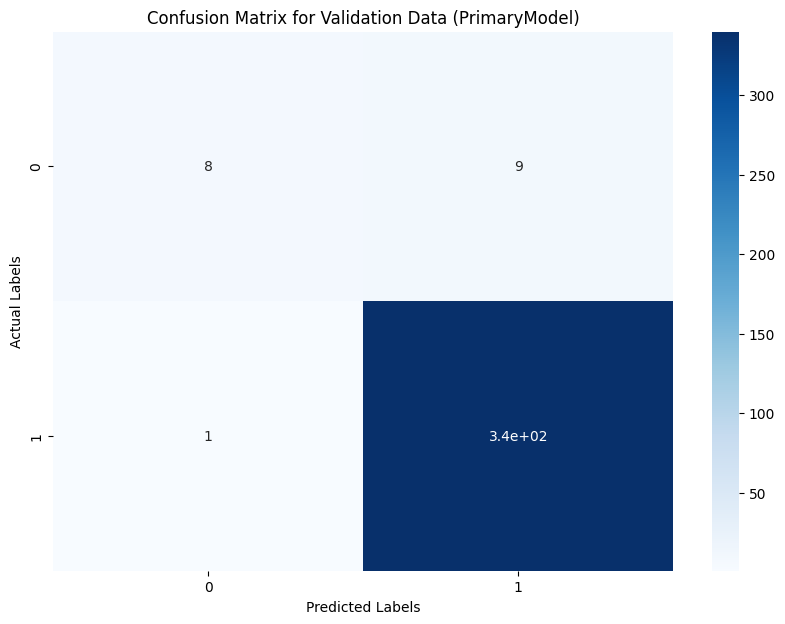

recall:  0.8888888888888888
accuracy:  0.9720670391061452
f1-score:  0.6153846153846153


In [ ]:
model = PrimaryModel
data = demo_data
batch_size = 256
accuracy, recall, precision, f1, confusion_matrix = get_metrics(model, data, batch_size)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix.cpu(), annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Validation Data (' + str(model.name) + ')')
plt.show()

print("recall: ",recall)
print("accuracy: ",accuracy)
print("f1-score: ",f1)

# **END OF DEMO**

In [ ]:
# THIS GET METRIC FUNCTINO WAS USED TO FOR THE FIGURES IN QUALITATIVE ANALYSIS ( THE FUNCTION FINDS AN EXAMPLE IN THE DATA SET WHERE THERE IS A FN TP OR TN)


def get_metrics(model, data, batch_size):
    torch.manual_seed(1)
    correct = 0
    total = 0
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives
    tn = 0  # True negatives
    counter = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False):
        imgs = imgs.unsqueeze(1)
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            model = model.cuda()
        output = model(imgs.float())
        counter +=1

        pred = output.max(1, keepdim=True)[1]
        pred = pred.squeeze()
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        print(pred)
        print(labels)

        iteration = 0

        while(iteration < 256):
          iteration += 1
          if(pred[iteration] == 0 and labels[iteration] == 1): # CHANGE THIS LINE DEPENDING ON WHAT
            print("FN!!!")
            print(iteration)


            first_sample, first_label = data[iteration]

            # Create a range of channel indices
            channel_indices = range(1, len(first_sample) + 1)

            # Plot the channel values
            plt.plot(channel_indices, first_sample)
            plt.xlabel('Channel Index')
            plt.ylabel('Channel Value')
            plt.title(f"First Sample (Label: {first_label}) in test_data")
            plt.grid(True)
            plt.show()

            break

        tp += ((pred == 1) & (labels == 1)).sum().item()
        fp += ((pred == 1) & (labels == 0)).sum().item()
        fn += ((pred == 0) & (labels == 1)).sum().item()
        tn += ((pred == 0) & (labels == 0)).sum().item()
        print(" fn is :",fn)



    accuracy = correct / total
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0
    recall = tp / (tp + fn) if tp + fn != 0 else 0.0
    f1 = 2*((recall*precision)/(recall+precision)) if recall + precision != 0 else 0.0
    confusion_matrix = torch.tensor([[tp, fp], [fn, tn]])
    return accuracy, recall, precision, f1, confusion_matrix

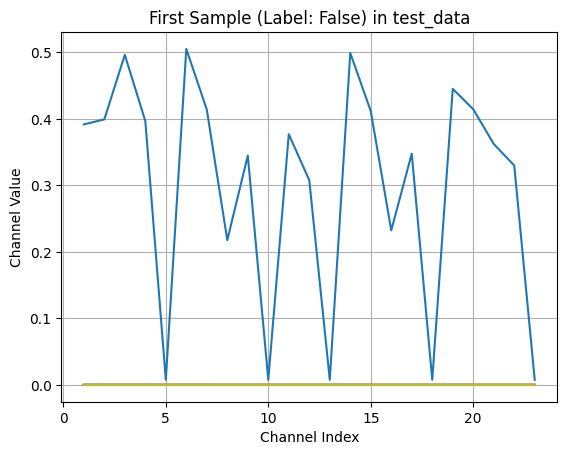

In [ ]:

#trying to visualize the extracted data
#153,69,1 (FN,TN,TP)
first_sample, first_label = test_data[153]

# Create a range of channel indices
channel_indices = range(1, len(first_sample) + 1)

# Plot the channel values
plt.plot(channel_indices, first_sample)
plt.xlabel('Channel Index')
plt.ylabel('Channel Value')
plt.title(f"First Sample (Label: {first_label}) in test_data")
plt.grid(True)
plt.show()


In [ ]:
#PRINTING the extracted data
print("true positve example, mean:", test_data[150][0][0][0])
print("true positve example, median:", test_data[150][0][0][1])
print("true positve example, variance:", test_data[150][0][0][2])
print("true positve example,  power spectral density's:")
print("true positve example, Frequeny band 0-4Hz:", test_data[150][0][0][3])
print("true positve example, Frequeny band 4-8Hz:", test_data[150][0][0][4])
print("true positve example, Frequeny band 8-12Hz:", test_data[150][0][0][5])
print("true positve example, Frequeny band 12-30Hz:", test_data[150][0][0][6])
print("true positve example, Frequeny band 30-55Hz:",test_data[150][0][0][7])
print("true positve example, Frequeny band 55-61Hz:",test_data[150][0][0][8])


true positve example, mean: 0.5047564346764347
true positve example, median: 6.989929284173643e-09
true positve example, variance: 5.45054945054945e-05
true positve example,  power spectral density's:
true positve example, Frequeny band 0-4Hz: 7.827577576297671e-06
true positve example, Frequeny band 4-8Hz: 3.6362832909219064e-06
true positve example, Frequeny band 8-12Hz: 1.650663729099827e-06
true positve example, Frequeny band 12-30Hz: 5.617538826851628e-07
true positve example, Frequeny band 30-55Hz: 3.908425927635994e-07
true positve example, Frequeny band 55-61Hz: 6.064002061793829e-08
